## CHAPTER 3: CORONA VIRUS DRUG DISCOVERY


### Objectives:

In part 3, we will be calculating molecular descriptors that are essentially quantitative description of the compound in the dataset, then we go ahead to prepare our dataset for model building.


## Import Libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from chembl_webresource_client.new_client import new_client
from sklearn.metrics import f1_score

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('Corona_pIC50.csv')
df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,Inactive,421.190,2.66050,0.0,4.0,4.869666
1,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,Inactive,293.347,3.63080,0.0,3.0,4.882397
2,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,Active,372.243,4.39330,0.0,3.0,6.008774
3,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,Active,419.243,4.23540,0.0,3.0,6.022276
4,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,Inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
86,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,Inactive,338.359,3.40102,0.0,5.0,4.974694
87,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,Inactive,296.366,3.44330,0.0,3.0,4.995679
88,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,Inactive,276.291,4.09564,0.0,3.0,4.939302
89,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,Inactive,278.307,3.29102,0.0,3.0,4.970616


### Select the columns we are interested in.

In [4]:
selection = pd.concat([df['canonical_smiles'], df['molecule_chembl_id']], axis=1)
selection


,canonical_smiles,molecule_chembl_id
0,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,CHEMBL185698
1,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,CHEMBL426082
2,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,CHEMBL365134
3,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,CHEMBL190743
4,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,CHEMBL365469
...,...,...
86,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,CHEMBL2146517
87,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,CHEMBL187460
88,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,CHEMBL363535
89,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,CHEMBL227075


In [5]:
selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [6]:
import glob
xml_files = glob.glob('*.xml')
xml_files.sort()
xml_files    

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [7]:
selection.canonical_smiles.shape[0]

91

###  Create a fingerprint list

In [8]:
fp_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKGraphOnly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'Pubchem',
 'SubstructureCount',
 'Substructure']

In [9]:
# Create a dictionary to hold the fingerprints

fp = dict(zip(fp_list, xml_files))
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKGraphOnly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'Pubchem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

In [10]:
fp['Pubchem']

'PubchemFingerprinter.xml'

### Calculate the descriptors

In [11]:
from padelpy import padeldescriptor

fingerprint = 'Pubchem'

fingerprint_output_file = ''.join([fingerprint, '.csv']) # Pubchem.csv

fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Pubchem.csv'
               #descriptortypes='PubchemFingerprinter.xml'
               descriptortypes = fingerprint_descriptortypes,
               detectaromaticity=True,
               standardizenitro=True,
               standardizetautomers=True,
               threads=2,
               removesalt=True,
               log=True,
               fingerprints=True)

In [12]:
descriptors = pd.read_csv(fingerprint_output_file)
descriptors

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL185698,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL426082,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL365134,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL190743,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL365469,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,CHEMBL2146517,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
87,CHEMBL187460,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88,CHEMBL363535,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89,CHEMBL227075,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This dataset contains cleaned molecular descriptors.

In [13]:
X_descriptors = descriptors.drop('Name', axis=1)
X_descriptors

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
87,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
88,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
89,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_y = df.pIC50
df_y

0     4.869666
1     4.882397
2     6.008774
3     6.022276
4     4.950782
        ...   
86    4.974694
87    4.995679
88    4.939302
89    4.970616
90    4.102923
Name: pIC50, Length: 91, dtype: float64

### Next we combine or concatenate X_descriptors and df_y

In [15]:
data = pd.concat([X_descriptors, df_y], axis=1)
data

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.869666
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.882397
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.008774
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.022276
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.950782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.974694
87,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.995679
88,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.939302
89,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.970616


## Save the new dataset.

In [16]:
data.to_csv('Corona_pubchem_fp.csv', index=False)

## Feature engineering.

In [17]:
#drop the target column

X = data.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
87,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
88,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
89,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Target variable is pIC50

y = data.pIC50
y

0     4.869666
1     4.882397
2     6.008774
3     6.022276
4     4.950782
        ...   
86    4.974694
87    4.995679
88    4.939302
89    4.970616
90    4.102923
Name: pIC50, Length: 91, dtype: float64

## Remove low variance feature.

In [19]:
from sklearn.feature_selection import VarianceThreshold

var_select = VarianceThreshold(threshold=(0.8*(1-0.8)))
X = var_select.fit_transform(X)
X.shape

(91, 202)

## Split our dataset into training and testing data.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
print('X train data:', X.shape)
print('\ny train data', y.shape)

X train data: (91, 202)

y train data (91,)


In [22]:
X_test.shape

(19, 202)

In [23]:
y_test.shape

(19,)

In [24]:
model = RandomForestRegressor(n_estimators=100)

np.random.seed(50) # we use a random seed function so that we obtain a single r2 score otherwise the result will vary

#Fit the model to the train data

model.fit(X_train, y_train)

# predict using the test data

prediction = model.predict(X_test)

# calculate the r2 score

r2_score = model.score(X_test, y_test)

r2_score

0.5633325569021066

In [26]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, prediction))
print('Mean squared error is:{}'.format(rmse))

Mean squared error is:0.5442901158189594


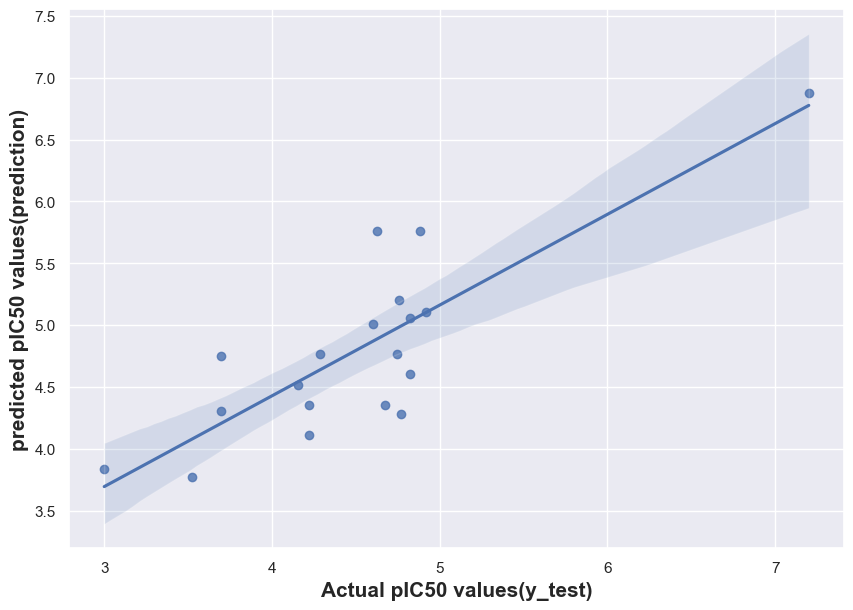

In [27]:
plt.figure(figsize=(10, 7))

sns.set()

sns.regplot(x=y_test, y=prediction)

plt.xlabel('Actual pIC50 values(y_test)', fontsize='15', fontweight='bold')

plt.ylabel('predicted pIC50 values(prediction)', fontsize='15',fontweight='bold')

plt.show()

### Observation:

We notice that our model score is low, this is due to the small amount of data we have used in our analysis, I have done the same analysis using Acetylcholinesterase and it returned a better accuracy score.

In [28]:
import lazypredict
from lazypredict.Supervised import LazyRegressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
model_train, prediction_train = clf.fit(X_train, X_test,y_train, y_test)
model_test, prediction_test = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:20<00:00,  2.05it/s]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [00:20<00:00,  2.07it/s]


In [29]:
model_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,52826000670948459739274026996116175669349286445...,-5399991179696953383767624559463575986211105421...,19140424541410826634496005252088373134913687945...,0.15
TransformedTargetRegressor,438582812289636342169600.00,-4483290970071838104748032.00,1744028204536.96,0.04
LinearRegression,438582812289636342169600.00,-4483290970071838104748032.00,1744028204536.96,0.02
KernelRidge,3.89,-28.52,4.48,0.03
GaussianProcessRegressor,2.72,-16.59,3.45,0.03
MLPRegressor,1.13,-0.36,0.96,0.32
LassoLars,1.12,-0.19,0.90,0.04
DummyRegressor,1.12,-0.19,0.90,0.03
Lasso,1.12,-0.19,0.90,0.03


In [41]:
prediction_test.tail(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
AdaBoostRegressor,1.04,0.61,0.52,0.12
GradientBoostingRegressor,1.04,0.61,0.51,0.20
LassoCV,1.03,0.64,0.49,6.85
NuSVR,1.03,0.70,0.45,0.02
ElasticNetCV,1.03,0.71,0.44,8.68
GammaRegressor,1.02,0.75,0.41,0.04
TweedieRegressor,1.02,0.75,0.41,0.03
KNeighborsRegressor,1.02,0.76,0.41,0.04
SVR,1.02,0.76,0.40,0.02


### Conclusion:

We can see that the best performing models are <b>BayesianRidge, KNeighborsRegressor, SVR</b>. After refreshing the notebook we notice some changes in the best perfoming models but the SVR and KNeighborsRegressor seem to always give a good accuracy.